# Sediment resuspension parameterization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import modules.mapping_functions as mf
import cmocean
import pickle
import xarray as xr
import scipy.io

%matplotlib inline

#### Parameters

In [3]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

#### Load files:

In [4]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [5]:
mat         = scipy.io .loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']
ts_mesh     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = ts_mesh['nav_lon'].values
ts_lats     = ts_mesh['nav_lat'].values

#### Calculations

In [6]:
tidal_speed_ANHA12 = mf.interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0
tidal_speed_ANHA12[tidal_speed_ANHA12 < 0.01]    = 0 # mask tidal speeds slower than 1 cm/s

In [31]:
gamma     = 0.065
# alpha_0_C = 0.3e-6*9*0.8*0.055/gamma # alpha_0 times tuning constant
alpha_0   = 0.80
resus_cst = 1.37e-6

old_erosion_rate     = tidal_speed_ANHA12**2
log_old_erosion_rate = np.log10(old_erosion_rate)

new_erosion_rate     = gamma*(1-np.exp(-tidal_speed_ANHA12**2/gamma))
log_new_erosion_rate = np.log10(new_erosion_rate)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [32]:
print(f'total constant is {resus_cst}')
print(f'gamma is {gamma}')

total constant is 1.37e-06
gamma is 0.065


$ resuspension = 1 - e^{-v^2} \approx 1 - (1 - v^2) = v^2$

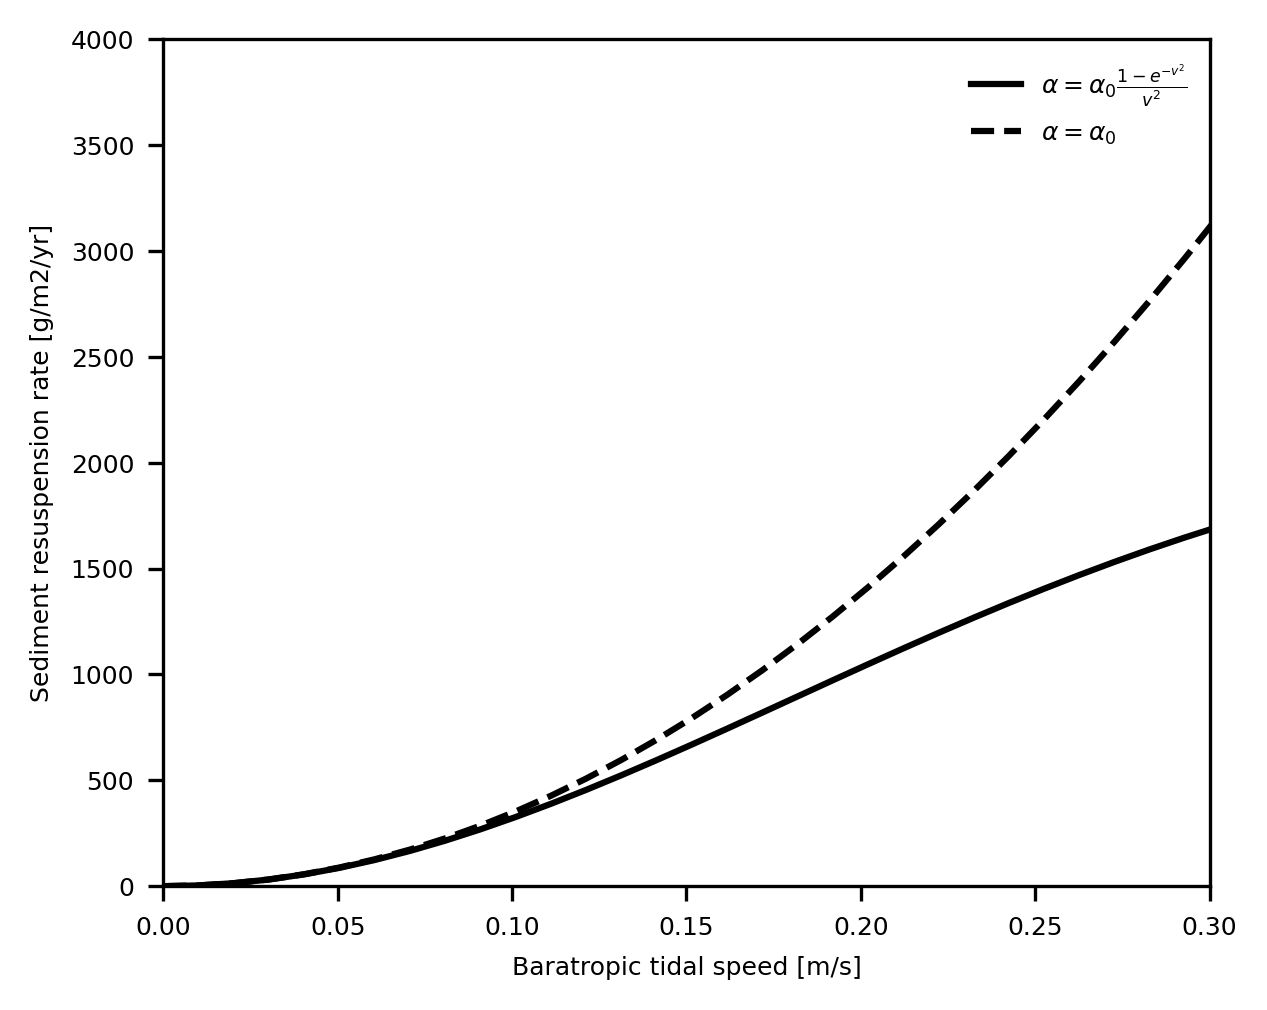

In [33]:
tide           = np.linspace(0,1,100)
# changing_solubility_resus_rate = resus_cst*alpha_0_C*gamma*(1-np.exp(-(tide)**2/gamma))*3600*24*365*1e3
# constant_solubility_resus_rate = resus_cst*alpha_0_C*(tide**2)*3600*24*365*1e3
changing_solubility_resus_rate = resus_cst*alpha_0*gamma*(1-np.exp(-(tide)**2/gamma))*3600*24*365*1e3
constant_solubility_resus_rate = resus_cst*alpha_0*(tide**2)*3600*24*365*1e3


fig, ax = plt.subplots(1,1, figsize=(4.5, 3.74), dpi=300)

ax.plot(tide, changing_solubility_resus_rate, '-k', label=r'$\alpha = \alpha_0\frac{1-e^{-v^2}}{v^2}$')
ax.plot(tide, constant_solubility_resus_rate, '--k', label=r'$\alpha = \alpha_0$')
ax.set_xlim([0, 0.3])
ax.set_ylim([0, 4e3])
ax.set_xlabel('Baratropic tidal speed [m/s]', fontsize=6)
ax.set_ylabel('Sediment resuspension rate [g/m2/yr]', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

ax.legend(fontsize=6, frameon=False)

## Plots

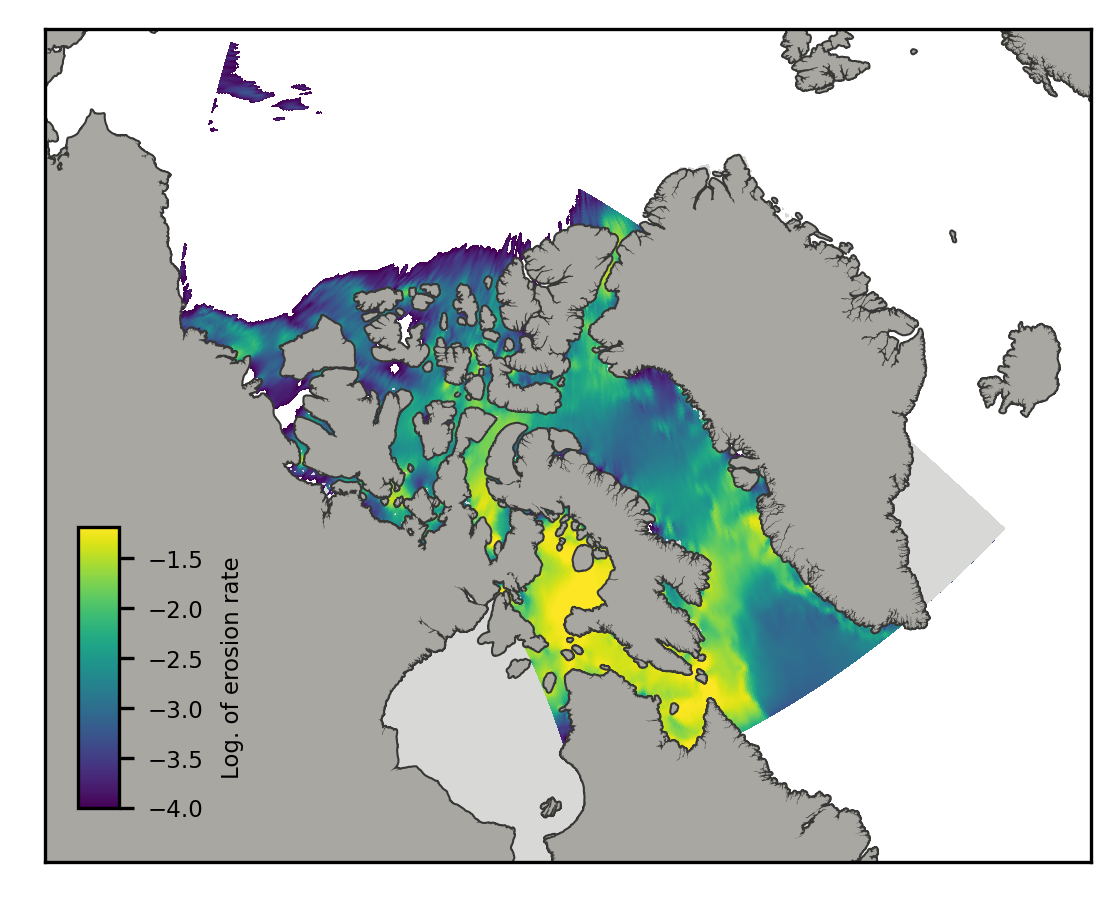

In [36]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
CB = proj1.pcolormesh(x_sub[imin:imax,jmin:jmax], y_sub[imin:imax,jmin:jmax], log_new_erosion_rate[imin:imax,jmin:jmax])

proj1.contourf(x_sub, y_sub, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

cbaxes = fig.add_axes([0.15, 0.18, 0.03, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes)
CBar.ax.tick_params(labelsize=5.5)
CBar.set_label('Log. of erosion rate', fontsize=5.5)

In [39]:
print('Units [g/m2/yr]')
print(f'Average erosion rate in domain: {resus_cst*np.average(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Median erosion rate in domain:  {resus_cst*np.median(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Maximum erosion rate in domain: {resus_cst*np.amax(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Minimum erosion rate in domain: {resus_cst*np.amin(new_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')

print('Units [g/m2/yr]')
print(f'Average erosion rate in domain: {resus_cst*np.average(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Median erosion rate in domain:  {resus_cst*np.median(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Maximum erosion rate in domain: {resus_cst*np.amax(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Minimum erosion rate in domain: {resus_cst*np.amin(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')

Units [g/m2/yr]
Average erosion rate in domain: 237.26
Median erosion rate in domain:  39.08
Maximum erosion rate in domain: 2808.28
Minimum erosion rate in domain: 0.00
Units [g/m2/yr]
Average erosion rate in domain: 466.53
Median erosion rate in domain:  39.36
Maximum erosion rate in domain: 62697.56
Minimum erosion rate in domain: 0.00


# Write to file:

In [41]:
file_write = xr.Dataset(
    {'er_rate': (("y","x"), new_erosion_rate)}, 
    coords = {
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        'long_name':'Erosion rate',
        'units':'kg/m2/s (when multipled by resus_cst)',
    }
)

In [42]:
file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/Pb-202207-forcing/erosion_rate-Pb-20220713.nc')